In [45]:
import pandas as pd
import plotly.express as px
import numpy as np
import torch_geometric as pyg
import torch
import networkx as nx
import pytorch_lightning as pl

In [2]:
climbs = pd.read_csv("data/climbs.csv")
grades = pd.read_csv("data/difficulty_grades.csv")
stats = pd.read_csv("data/climb_stats.csv")
holds = pd.read_csv("data/holes.csv")
placements = pd.read_csv("data/placements.csv")
hole_to_hold = placements.set_index("hole_id")['hold_id'].to_dict()
holds['hole_id'] = holds['id']
holds['hold_id'] = holds['id'].apply(lambda x:hole_to_hold[x])
holds.set_index("hold_id", inplace=True)

In [3]:
df = pd.merge(climbs.drop("angle", axis=1), stats, left_on="uuid", right_on="climb_uuid")
df['display_grade'] = df['display_difficulty'].apply(lambda x: grades.loc[int(x) + 1, "boulder_name"])
df['average_grade'] = df['difficulty_average'].apply(lambda x: grades.loc[int(x) + 1, "boulder_name"])
df = df[df['layout_id'] == 1]

In [17]:
df.iloc[0]['frames']

'p1145r12p1146r12p1149r13p1186r13p1201r13p1256r15p1267r13p1276r15p1307r13p1321r13p1322r13p1343r13p1356r13p1392r14p1454r15p1455r15p1456r15p1457r15p1506r15p1523r15p1527r15p1533r15p1535r15'

In [32]:
def encode_frames(frames: str, difficulty: int) -> pyg.data.Data:
    nodes = []
    colors = []
    pos = []
    for frame in frames.split("p")[1:]:
        hold_id, color = frame.split("r")
        hold_id = int(hold_id)
        color = int(color)
        hold = holds.loc[hold_id]
        nodes.append(hold_id)
        colors.append(color - 12)
        pos.append([hold.x, hold.y])
    return pyg.data.Data(
        x=torch.tensor(nodes),
        pos=torch.tensor(pos),
        colors=torch.tensor(colors),
        y=torch.tensor(difficulty),
    )

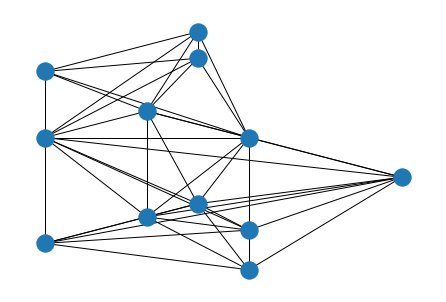

In [65]:
class KilterDataset(pyg.data.InMemoryDataset):
    def __init__(
        self,
        root,
        split: str = "train",
        transform=None,
        pre_transform=None,
        pre_filter=None,
    ):
        assert split in ["train", "val", "test"]
        super().__init__(root, transform, pre_transform, pre_filter)
        # self.load(self.processed_paths[0])
        # For PyG<2.4:
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [
            "climbs.csv",
            "climb_stats.csv",
            "difficulty_grades.csv",
            "holes.csv",
            "placements.csv",
        ]

    @property
    def processed_file_names(self):
        return ["train.pt", "val.pt", "test.pt"]

    def process(self):
        # Read data into huge `Data` list.
        data_list = [...]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])
        # For PyG<2.4:
        # torch.save(self.collate(data_list), self.processed_paths[0])